# F8 Week 3 - Sequential SVM→GP Pipeline

## Production Implementation

**Strategy:** Linear SVM pre-screening → GP optimization  
**Data:** Week 2 results (41 samples, 8D)  
**Goal:** Generate Week 3 submission

---

## Pipeline Overview:
1. ✅ Load Week 2 data (41 samples)
2. ✅ Train Linear SVM classifier (top 30% = "good")
3. ✅ Train Gaussian Process model
4. ✅ Generate 10,000 candidate points
5. ✅ SVM filter: 70% approved + 30% boundary
6. ✅ GP optimize: Find max Expected Improvement
7. ✅ Comprehensive visualizations
8. ✅ Format for submission

In [107]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
function_number = 8
print("="*70)
print("F8 WEEK 3: SEQUENTIAL SVM → GP PIPELINE")
print("="*70)
print("\n✓ Libraries loaded")
print("\nPipeline: Linear SVM filtering → GP optimization")

F8 WEEK 3: SEQUENTIAL SVM → GP PIPELINE

✓ Libraries loaded

Pipeline: Linear SVM filtering → GP optimization


## 📁 STEP 1: Load Data

In [108]:
# Load Week 2 data (includes initial 10 + Week 1 result)
X = np.load('f8_W3_inputs.npy')
Y = np.load('f8_W3_outputs.npy')

print("Data Loaded:")
print(f"  Shape: {X.shape}")
print(f"  Samples: {len(X)}")
print(f"  Dimensions: {X.shape[1]}")
print(f"  n/p ratio: {len(X)/X.shape[1]:.2f}")
print(f"\nOutput Statistics:")
print(f"  Best:   {Y.max():.6f}")
print(f"  Worst:  {Y.min():.6f}")
print(f"  Mean:   {Y.mean():.6f}")
print(f"  Median: {np.median(Y):.6f}")
print(f"  Std:    {Y.std():.6f}")
print(f"\n🎯 8D Optimization Challenge:")
print(f"  Coverage: {100*len(X)/1e8:.6f}% (0.00004%)")
print(f"  Grid search would take: 1.9 million years!")

Data Loaded:
  Shape: (42, 8)
  Samples: 42
  Dimensions: 8
  n/p ratio: 5.25

Output Statistics:
  Best:   9.831962
  Worst:  5.592193
  Mean:   7.891720
  Median: 7.940817
  Std:    0.989375

🎯 8D Optimization Challenge:
  Coverage: 0.000042% (0.00004%)
  Grid search would take: 1.9 million years!


## 🤖 STEP 2: Train Linear SVM

In [109]:
# Create binary classification: top 30% = "good"
threshold = np.percentile(Y, 70)
y_binary = (Y > threshold).astype(int)

print("Binary Classification Created:")
print(f"  Threshold: {threshold:.6f} (70th percentile)")
print(f"  Good (1):  {y_binary.sum()} samples ({y_binary.sum()/len(Y)*100:.1f}%)")
print(f"  Bad (0):   {len(y_binary)-y_binary.sum()} samples ({(1-y_binary.sum()/len(Y))*100:.1f}%)")

Binary Classification Created:
  Threshold: 8.468900 (70th percentile)
  Good (1):  13 samples (31.0%)
  Bad (0):   29 samples (69.0%)


In [110]:
print("\n" + "="*70)
print("TRAINING LINEAR SVM")
print("="*70)

# Train Linear SVM
svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm.fit(X, y_binary)

# Cross-validation
cv_scores = cross_val_score(svm, X, y_binary, cv=3)

print(f"\nPerformance:")
print(f"  Training accuracy:  {svm.score(X, y_binary):.1%}")
print(f"  CV accuracy:        {cv_scores.mean():.1%} ± {cv_scores.std():.1%}")
print(f"  Support vectors:    {len(svm.support_)} ({len(svm.support_)/len(X)*100:.1f}%)")

# Feature weights
weights = svm.coef_[0]

print(f"\n" + "="*70)
print("LINEAR SVM FEATURE WEIGHTS")
print("="*70)
print(f"\n  Rank  Dim    Weight    |Weight|   Interpretation")
print(f"  " + "-"*60)

importance_order = np.argsort(np.abs(weights))[::-1]

for rank, dim in enumerate(importance_order, 1):
    w = weights[dim]
    abs_w = abs(w)
    direction = "Positive (→ Good)" if w > 0 else "Negative (→ Bad)"
    magnitude = "HIGH" if abs_w > 0.5 else ("MED" if abs_w > 0.2 else "LOW")
    
    print(f"  {rank:2d}.   X{dim+1}    {w:+7.3f}    {abs_w:6.3f}    {magnitude:4s}  {direction}")

print(f"\n💡 Interpretation:")
print(f"   Positive weight → Increasing dimension improves classification as 'Good'")
print(f"   Negative weight → Increasing dimension worsens classification")
print(f"   Large |weight| → Important for decision boundary")


TRAINING LINEAR SVM

Performance:
  Training accuracy:  85.7%
  CV accuracy:        83.3% ± 6.7%
  Support vectors:    23 (54.8%)

LINEAR SVM FEATURE WEIGHTS

  Rank  Dim    Weight    |Weight|   Interpretation
  ------------------------------------------------------------
   1.   X1     -1.582     1.582    HIGH  Negative (→ Bad)
   2.   X3     -1.573     1.573    HIGH  Negative (→ Bad)
   3.   X2     -1.419     1.419    HIGH  Negative (→ Bad)
   4.   X7     -0.900     0.900    HIGH  Negative (→ Bad)
   5.   X6     -0.445     0.445    MED   Negative (→ Bad)
   6.   X4     -0.318     0.318    MED   Negative (→ Bad)
   7.   X8     -0.199     0.199    LOW   Negative (→ Bad)
   8.   X5     +0.078     0.078    LOW   Positive (→ Good)

💡 Interpretation:
   Positive weight → Increasing dimension improves classification as 'Good'
   Negative weight → Increasing dimension worsens classification
   Large |weight| → Important for decision boundary


## 📈 STEP 3: Train Gaussian Process

In [111]:
print("\n" + "="*70)
print("TRAINING GAUSSIAN PROCESS")
print("="*70)

# Kernel for 8D
kernel = ConstantKernel(1.0, (1e-10, 1e10)) * \
         Matern(0.3, (0.01, 10.0), nu=2.5) + \
         WhiteKernel(1e-10, (1e-12, 1e-2))

# Train GP
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=50,
    normalize_y=True,
    random_state=42
)

gp.fit(X, Y)

print(f"\nPerformance:")
print(f"  R² score: {gp.score(X, Y):.3f}")
print(f"  Log marginal likelihood: {gp.log_marginal_likelihood_value_:.2f}")

# GP marginal effects
print(f"\nGP Marginal Effects:")
print(f"  Dim   Effect    Rank")
print(f"  " + "-"*30)

gp_effects = np.zeros(8)
for dim in range(8):
    X_test = np.tile(X.mean(axis=0), (50, 1))
    X_test[:, dim] = np.linspace(0, 1, 50)
    Y_pred = gp.predict(X_test)
    gp_effects[dim] = Y_pred.max() - Y_pred.min()

for rank, dim in enumerate(np.argsort(gp_effects)[::-1], 1):
    print(f"  X{dim+1}    {gp_effects[dim]:6.3f}    {rank}")

# SVM-GP agreement
svm_norm = np.abs(weights) / np.abs(weights).max()
gp_norm = gp_effects / gp_effects.max()
correlation = np.corrcoef(svm_norm, gp_norm)[0, 1]

print(f"\nSVM-GP Feature Correlation: {correlation:.3f}")
if correlation > 0.7:
    print(f"  ✓ Strong agreement between SVM and GP")
elif correlation > 0.4:
    print(f"  ~ Moderate agreement")
else:
    print(f"  ✗ Weak agreement - methods see different patterns")


TRAINING GAUSSIAN PROCESS

Performance:
  R² score: 1.000
  Log marginal likelihood: -21.71

GP Marginal Effects:
  Dim   Effect    Rank
  ------------------------------
  X3     2.451    1
  X1     1.651    2
  X7     1.246    3
  X2     0.753    4
  X4     0.677    5
  X5     0.358    6
  X6     0.264    7
  X8     0.172    8

SVM-GP Feature Correlation: 0.819
  ✓ Strong agreement between SVM and GP


## 🔄 STEP 4: Sequential Pipeline - Generate & Filter

In [112]:
print("\n" + "="*70)
print("GENERATING CANDIDATE POINTS")
print("="*70)

np.random.seed(42)
n_candidates = 10000
X_candidates = np.random.uniform(0, 1, (n_candidates, 8))

print(f"\nGenerated {n_candidates:,} random candidates in 8D space")


GENERATING CANDIDATE POINTS

Generated 10,000 random candidates in 8D space


In [113]:
print("\n" + "="*70)
print("SVM FILTERING (70% APPROVED + 30% BOUNDARY)")
print("="*70)

# SVM predictions
svm_predictions = svm.predict(X_candidates)
svm_probabilities = svm.predict_proba(X_candidates)[:, 1]

print(f"\nSVM Classification:")
print(f"  Predicted 'Good': {(svm_predictions == 1).sum():,} ({(svm_predictions == 1).sum()/n_candidates*100:.1f}%)")
print(f"  Predicted 'Bad':  {(svm_predictions == 0).sum():,} ({(svm_predictions == 0).sum()/n_candidates*100:.1f}%)")

# Strategy: 70% SVM-approved + 30% boundary
n_svm = int(0.7 * n_candidates)
n_boundary = int(0.3 * n_candidates)

print(f"\nFiltering Strategy:")
print(f"  Target SVM-approved:  {n_svm:,} (70%)")
print(f"  Target boundary:      {n_boundary:,} (30%)")

# Get SVM-approved candidates (sorted by confidence)
svm_good_idx = np.where(svm_predictions == 1)[0]

if len(svm_good_idx) > 0:
    svm_conf_order = np.argsort(svm_probabilities[svm_good_idx])[::-1]
    selected_idx = svm_good_idx[svm_conf_order[:min(n_svm, len(svm_good_idx))]]
    X_svm_approved = X_candidates[selected_idx]
    print(f"\n  SVM approved (by confidence): {len(X_svm_approved):,}")
else:
    print(f"\n  ⚠️  No 'good' predictions! Using top {n_svm} by probability")
    top_idx = np.argsort(svm_probabilities)[::-1][:n_svm]
    X_svm_approved = X_candidates[top_idx]

# Boundary candidates (any dim < 0.1 or > 0.9)
boundary_mask = (X_candidates < 0.1).any(axis=1) | (X_candidates > 0.9).any(axis=1)
X_boundary_all = X_candidates[boundary_mask]

print(f"  Boundary candidates available: {len(X_boundary_all):,}")

if len(X_boundary_all) >= n_boundary:
    boundary_idx = np.random.choice(len(X_boundary_all), n_boundary, replace=False)
    X_boundary_sample = X_boundary_all[boundary_idx]
else:
    X_boundary_sample = X_boundary_all
    n_needed = n_boundary - len(X_boundary_all)
    random_idx = np.random.choice(n_candidates, n_needed, replace=False)
    X_boundary_sample = np.vstack([X_boundary_sample, X_candidates[random_idx]])

# Combine
X_filtered = np.vstack([X_svm_approved, X_boundary_sample])

print(f"\n✓ Filtered Set Created:")
print(f"  SVM-approved:     {len(X_svm_approved):,}")
print(f"  Boundary explore: {len(X_boundary_sample):,}")
print(f"  Total:            {len(X_filtered):,}")
print(f"  Reduction:        {n_candidates:,} → {len(X_filtered):,}")


SVM FILTERING (70% APPROVED + 30% BOUNDARY)

SVM Classification:
  Predicted 'Good': 1,820 (18.2%)
  Predicted 'Bad':  8,180 (81.8%)

Filtering Strategy:
  Target SVM-approved:  7,000 (70%)
  Target boundary:      3,000 (30%)

  SVM approved (by confidence): 1,820
  Boundary candidates available: 8,304

✓ Filtered Set Created:
  SVM-approved:     1,820
  Boundary explore: 3,000
  Total:            4,820
  Reduction:        10,000 → 4,820


## 🎯 STEP 5: GP Optimization - Find Max EI

In [114]:
def expected_improvement(X_new, gp, y_best, xi=0.1):
    """Expected Improvement acquisition function."""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    improvement = mu - y_best - xi
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    return ei

In [115]:
print("\n" + "="*70)
print("GP OPTIMIZATION ON FILTERED SET")
print("="*70)

y_best = Y.max()
print(f"\nCurrent best: {y_best:.6f}")
print(f"\nCalculating Expected Improvement for {len(X_filtered):,} candidates...")
print(f"Using xi=0.1 (aggressive exploration for 8D)")

# Calculate EI
ei_values = expected_improvement(X_filtered, gp, y_best, xi=0.1)

# Get all GP predictions
mu_all, sigma_all = gp.predict(X_filtered, return_std=True)

print(f"\nEI Statistics:")
print(f"  Maximum: {ei_values.max():.6f}")
print(f"  Mean:    {ei_values.mean():.6f}")
print(f"  Median:  {np.median(ei_values):.6f}")

# Select max EI
best_idx = np.argmax(ei_values)
x_next = X_filtered[best_idx]
ei_next = ei_values[best_idx]
mu_next = mu_all[best_idx]
sigma_next = sigma_all[best_idx]

print(f"\n" + "="*70)
print("🎯 WEEK 3 RECOMMENDATION (MAXIMUM EI)")
print("="*70)

print(f"\nSelected Point:")
print(f"  {x_next}")

print(f"\nGP Predictions:")
print(f"  Expected value (mu):    {mu_next:.6f}")
print(f"  Uncertainty (sigma):    {sigma_next:.6f}")
print(f"  Expected Improvement:   {ei_next:.6f}")

print(f"\nPerformance Metrics:")
print(f"  Current best:           {y_best:.6f}")
print(f"  Predicted improvement:  {mu_next - y_best:+.6f}")
print(f"  Predicted gain:         {((mu_next/y_best - 1)*100):+.2f}%")

print(f"\nRankings:")
print(f"  Rank by mu:    {(mu_all >= mu_next).sum():4d} / {len(mu_all)}")
print(f"  Rank by sigma: {(sigma_all >= sigma_next).sum():4d} / {len(sigma_all)}")
print(f"  Rank by EI:       1 / {len(ei_values)} (maximum by definition)")

# SVM confidence
svm_conf = svm.predict_proba(x_next.reshape(1, -1))[0, 1]
print(f"\nSVM Assessment:")
print(f"  P(Good): {svm_conf:.1%}")
if svm_conf > 0.7:
    print(f"  ✓ High SVM confidence - in 'good' region")
elif svm_conf > 0.3:
    print(f"  ~ Moderate SVM confidence")
else:
    print(f"  ⚠️  Low SVM confidence - GP exploring beyond SVM")

# Check origin
is_svm = best_idx < len(X_svm_approved)
print(f"\nSource:")
if is_svm:
    print(f"  From SVM-approved set (70%)")
else:
    print(f"  From boundary exploration set (30%)")


GP OPTIMIZATION ON FILTERED SET

Current best: 9.831962

Calculating Expected Improvement for 4,820 candidates...
Using xi=0.1 (aggressive exploration for 8D)

EI Statistics:
  Maximum: 0.083813
  Mean:    0.001145
  Median:  0.000000

🎯 WEEK 3 RECOMMENDATION (MAXIMUM EI)

Selected Point:
  [0.01200511 0.36580792 0.00205091 0.16545827 0.44785043 0.53508742
 0.1529286  0.74521628]

GP Predictions:
  Expected value (mu):    9.951210
  Uncertainty (sigma):    0.184966
  Expected Improvement:   0.083813

Performance Metrics:
  Current best:           9.831962
  Predicted improvement:  +0.119247
  Predicted gain:         +1.21%

Rankings:
  Rank by mu:       1 / 4820
  Rank by sigma: 3306 / 4820
  Rank by EI:       1 / 4820 (maximum by definition)

SVM Assessment:
  P(Good): 99.4%
  ✓ High SVM confidence - in 'good' region

Source:
  From SVM-approved set (70%)


## 📊 STEP 6: Detailed Analysis

In [116]:
print("\n" + "="*70)
print("DIMENSION-BY-DIMENSION ANALYSIS")
print("="*70)

print(f"\n  Dim   Value   SVM Weight   GP Effect   Boundary?   Alignment")
print(f"  " + "-"*70)

for dim in range(8):
    val = x_next[dim]
    svm_w = weights[dim]
    gp_eff = gp_effects[dim]
    
    at_boundary = "YES" if (val < 0.1 or val > 0.9) else "   "
    
    # Check alignment between value and weights
    if svm_w < -0.5:  # Strong negative
        alignment = "✓ Low" if val < 0.3 else "✗ Should be lower"
    elif svm_w > 0.5:  # Strong positive  
        alignment = "✓ High" if val > 0.7 else "✗ Should be higher"
    else:
        alignment = "~ Medium range OK"
    
    print(f"  X{dim+1}    {val:.3f}    {svm_w:+6.3f}      {gp_eff:5.3f}     {at_boundary}       {alignment}")

n_boundary_dims = ((x_next < 0.1) | (x_next > 0.9)).sum()
print(f"\nBoundary Summary:")
print(f"  Dimensions at boundary: {n_boundary_dims}")
if n_boundary_dims >= 3:
    print(f"  → BOLD exploration (like Week 2)")
elif n_boundary_dims >= 1:
    print(f"  → MODERATE exploration")
else:
    print(f"  → CONSERVATIVE (no boundaries)")


DIMENSION-BY-DIMENSION ANALYSIS

  Dim   Value   SVM Weight   GP Effect   Boundary?   Alignment
  ----------------------------------------------------------------------
  X1    0.012    -1.582      1.651     YES       ✓ Low
  X2    0.366    -1.419      0.753               ✗ Should be lower
  X3    0.002    -1.573      2.451     YES       ✓ Low
  X4    0.165    -0.318      0.677               ~ Medium range OK
  X5    0.448    +0.078      0.358               ~ Medium range OK
  X6    0.535    -0.445      0.264               ~ Medium range OK
  X7    0.153    -0.900      1.246               ✓ Low
  X8    0.745    -0.199      0.172               ~ Medium range OK

Boundary Summary:
  Dimensions at boundary: 2
  → MODERATE exploration


## 📈 STEP 7: Visualizations

Creating acquisition curves for F8...


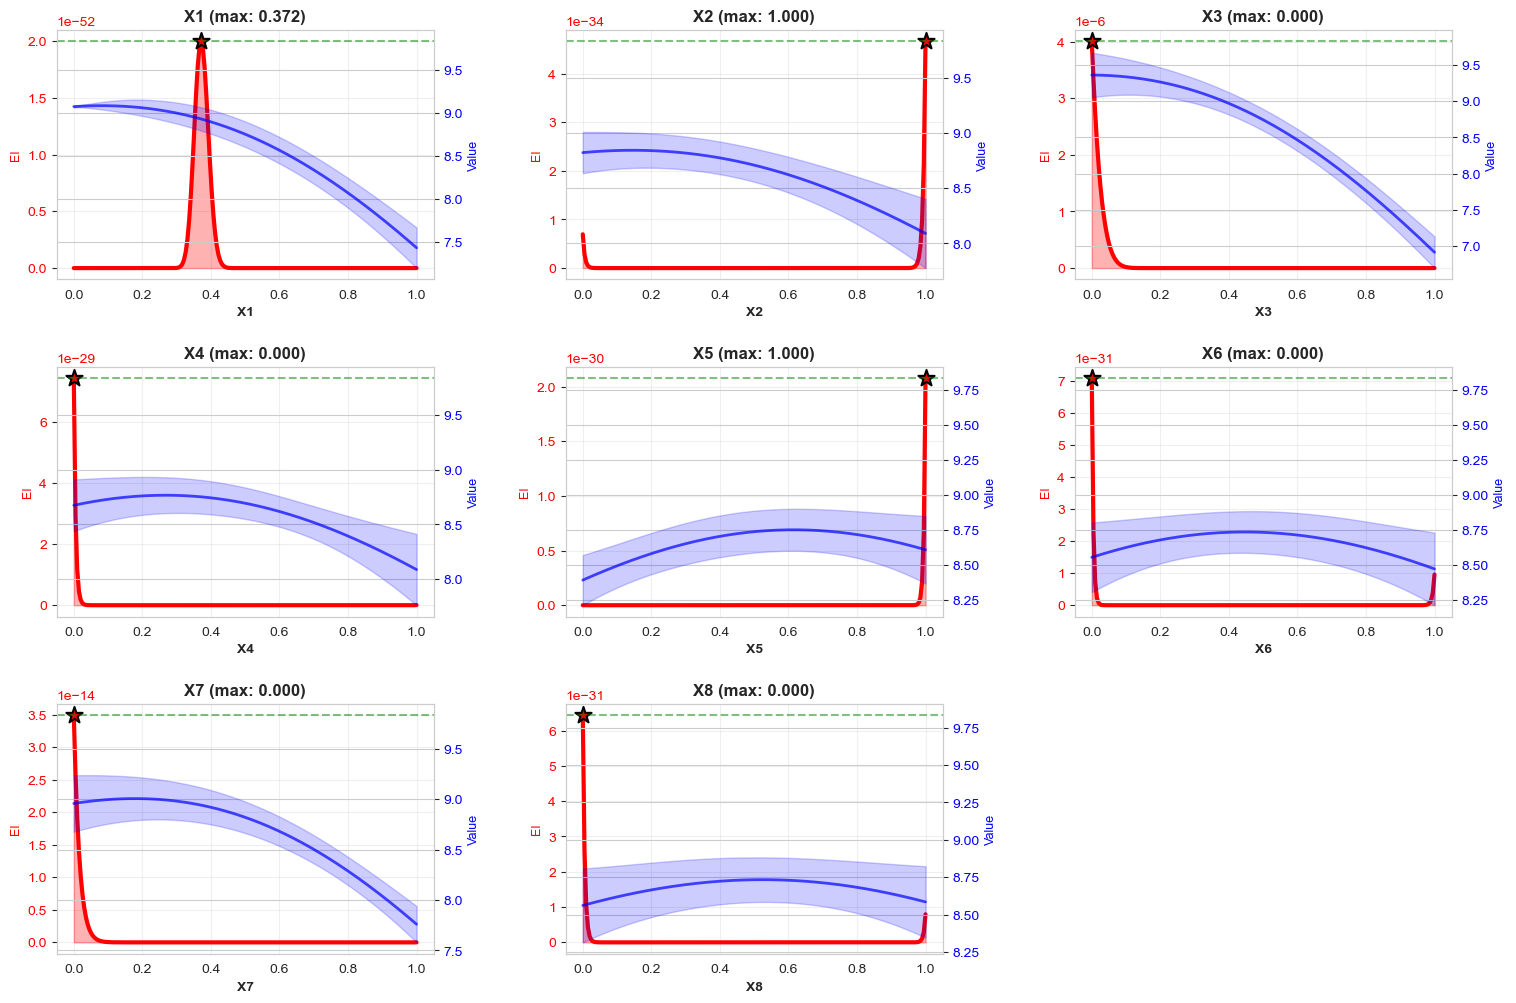

✓ Saved!


In [117]:
print(f'Creating acquisition curves for F{function_number}...')

# Get dimensions from data
n_dims = X.shape[1]

# Calculate grid size
n_cols = 3
n_rows = (n_dims + n_cols - 1) // n_cols  # Ceiling division

fig = plt.figure(figsize=(18, 4 * n_rows))
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.35)

for dim in range(n_dims):  # ✅ Correct for any function!
    ax = fig.add_subplot(gs[dim // n_cols, dim % n_cols])
    ax2 = ax.twinx()
    
    x1 = np.linspace(0, 1, 200)
    Xt = np.tile(X.mean(axis=0), (200, 1))
    Xt[:, dim] = x1
    
    m, s = gp.predict(Xt, return_std=True)
    e = expected_improvement(Xt, gp, y_best, 0.1)
    
    # GP plot
    ax2.plot(x1, m, 'b-', lw=2, alpha=0.7)
    ax2.fill_between(x1, m - 2*s, m + 2*s, alpha=0.2, color='blue')
    ax2.axhline(y_best, color='green', ls='--', alpha=0.5)
    ax2.set_ylabel('Value', color='blue', fontsize=9)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # EI plot
    ax.plot(x1, e, 'r-', lw=3)
    ax.fill_between(x1, 0, e, alpha=0.3, color='red')
    
    mi = np.argmax(e)
    ax.scatter(x1[mi], e[mi], color='red', s=150, marker='*', 
              zorder=5, edgecolors='black', lw=1.5)
    
    ax.set_xlabel(f'X{dim+1}', fontweight='bold')
    ax.set_ylabel('EI', color='red', fontsize=9)
    ax.set_title(f'X{dim+1} (max: {x1[mi]:.3f})', fontweight='bold')
    ax.tick_params(axis='y', labelcolor='red')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'Capstone_F{function_number}_W3_acquisition.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved!')

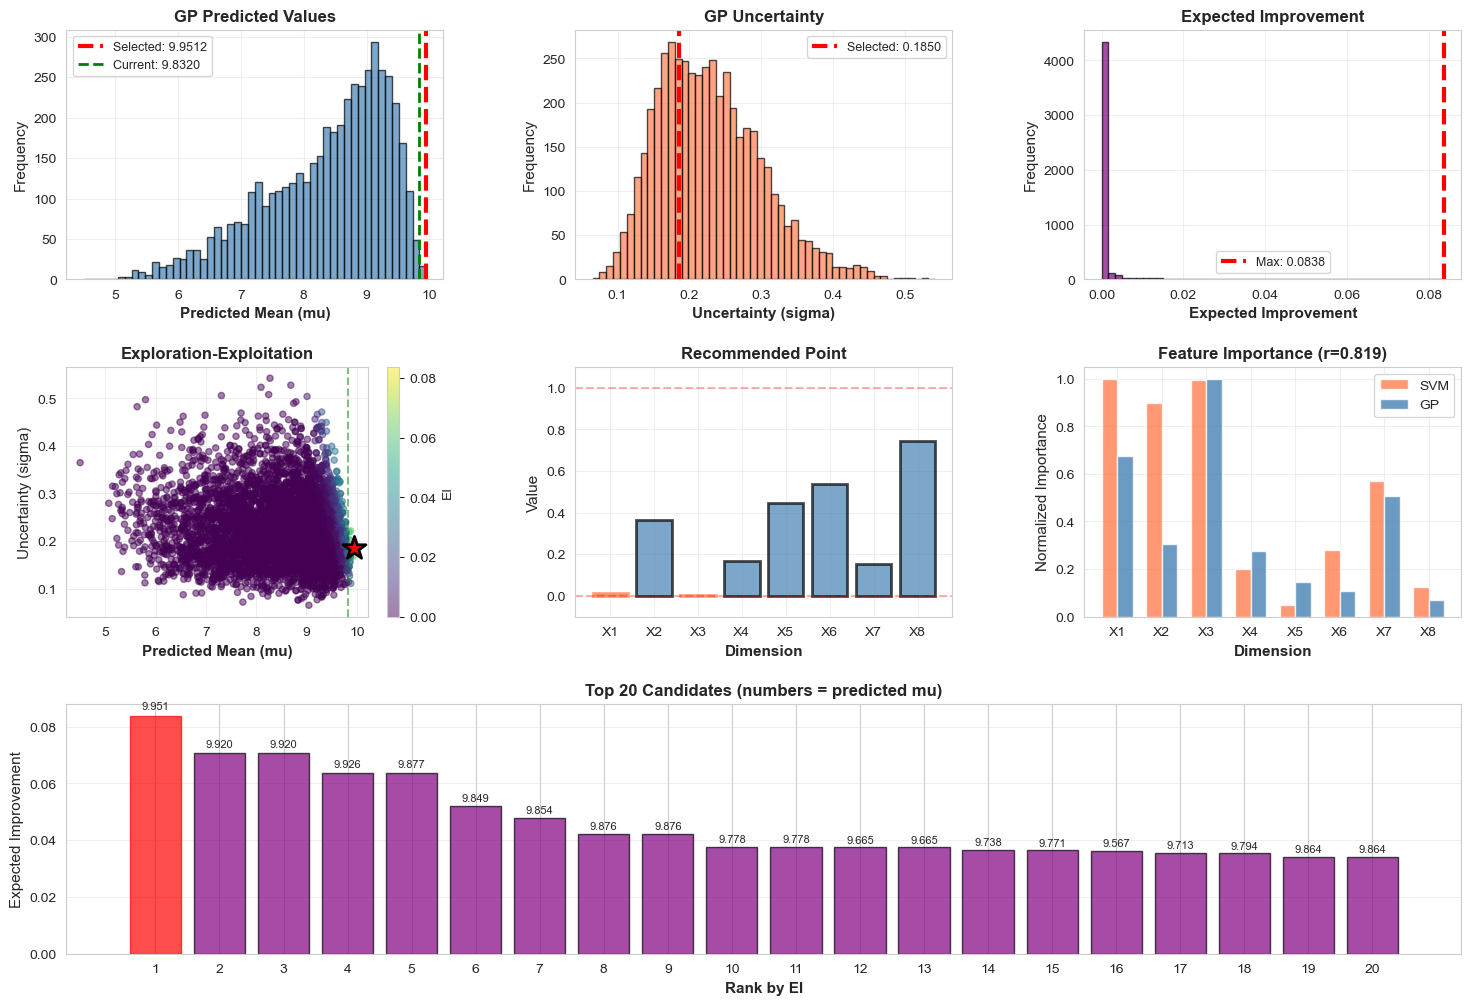


✓ Saved: f8_w3_sequential_complete.png


In [118]:
# Main visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1. Mu distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(mu_all, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(mu_next, color='red', linestyle='--', linewidth=3, label=f'Selected: {mu_next:.4f}')
ax1.axvline(y_best, color='green', linestyle='--', linewidth=2, label=f'Current: {y_best:.4f}')
ax1.set_xlabel('Predicted Mean (mu)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('GP Predicted Values', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# 2. Sigma distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(sigma_all, bins=50, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(sigma_next, color='red', linestyle='--', linewidth=3, label=f'Selected: {sigma_next:.4f}')
ax2.set_xlabel('Uncertainty (sigma)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('GP Uncertainty', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# 3. EI distribution
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(ei_values, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(ei_next, color='red', linestyle='--', linewidth=3, label=f'Max: {ei_next:.4f}')
ax3.set_xlabel('Expected Improvement', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Expected Improvement', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# 4. Mu vs Sigma
ax4 = fig.add_subplot(gs[1, 0])
scatter = ax4.scatter(mu_all, sigma_all, c=ei_values, cmap='viridis', alpha=0.5, s=20)
ax4.scatter(mu_next, sigma_next, color='red', s=300, marker='*', edgecolors='black', linewidth=2, zorder=5)
ax4.axvline(y_best, color='green', linestyle='--', alpha=0.5)
ax4.set_xlabel('Predicted Mean (mu)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Uncertainty (sigma)', fontsize=11)
ax4.set_title('Exploration-Exploitation', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='EI')

# 5. Dimension values
ax5 = fig.add_subplot(gs[1, 1])
dims = np.arange(8)
bars = ax5.bar(dims, x_next, alpha=0.7, color='steelblue', edgecolor='black', linewidth=2)
for i, val in enumerate(x_next):
    if val < 0.1 or val > 0.9:
        bars[i].set_color('coral')
ax5.axhline(0, color='red', linestyle='--', alpha=0.3)
ax5.axhline(1, color='red', linestyle='--', alpha=0.3)
ax5.set_xlabel('Dimension', fontsize=11, fontweight='bold')
ax5.set_ylabel('Value', fontsize=11)
ax5.set_title('Recommended Point', fontsize=12, fontweight='bold')
ax5.set_xticks(dims)
ax5.set_xticklabels([f'X{i+1}' for i in dims])
ax5.set_ylim(-0.1, 1.1)
ax5.grid(alpha=0.3)

# 6. Feature importance
ax6 = fig.add_subplot(gs[1, 2])
svm_norm = np.abs(weights) / np.abs(weights).max()
gp_norm = gp_effects / gp_effects.max()
width = 0.35
ax6.bar(dims - width/2, svm_norm, width, label='SVM', alpha=0.8, color='coral')
ax6.bar(dims + width/2, gp_norm, width, label='GP', alpha=0.8, color='steelblue')
ax6.set_xlabel('Dimension', fontsize=11, fontweight='bold')
ax6.set_ylabel('Normalized Importance', fontsize=11)
ax6.set_title(f'Feature Importance (r={correlation:.3f})', fontsize=12, fontweight='bold')
ax6.set_xticks(dims)
ax6.set_xticklabels([f'X{i+1}' for i in dims])
ax6.legend()
ax6.grid(alpha=0.3)

# 7. Top 20 candidates
ax7 = fig.add_subplot(gs[2, :])
top_20_idx = np.argsort(ei_values)[::-1][:20]
bars = ax7.bar(range(20), ei_values[top_20_idx], alpha=0.7, color='purple', edgecolor='black')
bars[0].set_color('red')
for i, (ei, mu) in enumerate(zip(ei_values[top_20_idx], mu_all[top_20_idx])):
    ax7.text(i, ei + ei.max()*0.02, f'{mu:.3f}', ha='center', va='bottom', fontsize=8)
ax7.set_xlabel('Rank by EI', fontsize=11, fontweight='bold')
ax7.set_ylabel('Expected Improvement', fontsize=11)
ax7.set_title('Top 20 Candidates (numbers = predicted mu)', fontsize=12, fontweight='bold')
ax7.set_xticks(range(20))
ax7.set_xticklabels([f'{i+1}' for i in range(20)])
ax7.grid(axis='y', alpha=0.3)

plt.savefig('f8_w3_sequential_complete.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: f8_w3_sequential_complete.png")

## 📋 STEP 8: Format for Submission

In [119]:
# Format for submission
formatted = "-".join([f"{val:.6f}" for val in x_next])

print("="*70)
print("WEEK 3 SUBMISSION - F8")
print("="*70)

print(f"\nStrategy: Sequential Linear SVM → GP")
print(f"\n📋 COPY THIS FOR PORTAL:\n")
print(formatted)
print("\n" + "="*70)

# Save to file
with open('f8_week3_submission.txt', 'w', encoding='utf-8') as f:
    f.write("F8 WEEK 3 SUBMISSION\n")
    f.write("="*70 + "\n\n")
    f.write("RECOMMENDATION:\n")
    f.write(formatted + "\n\n")
    f.write("STRATEGY: Sequential SVM → GP Pipeline\n")
    f.write("  1. Linear SVM (70% approved + 30% boundary)\n")
    f.write("  2. GP optimization (xi=0.1)\n")
    f.write("  3. Maximum Expected Improvement\n\n")
    f.write("PERFORMANCE:\n")
    f.write(f"  SVM CV: {cv_scores.mean():.1%}\n")
    f.write(f"  GP R²: {gp.score(X, Y):.3f}\n")
    f.write(f"  SVM-GP correlation: {correlation:.3f}\n\n")
    f.write("PREDICTION:\n")
    f.write(f"  Expected value: {mu_next:.6f}\n")
    f.write(f"  Uncertainty: {sigma_next:.6f}\n")
    f.write(f"  EI: {ei_next:.6f}\n")
    f.write(f"  Predicted gain: {((mu_next/y_best-1)*100):+.2f}%\n")

print("\n✓ Saved: f8_week3_submission.txt")

WEEK 3 SUBMISSION - F8

Strategy: Sequential Linear SVM → GP

📋 COPY THIS FOR PORTAL:

0.012005-0.365808-0.002051-0.165458-0.447850-0.535087-0.152929-0.745216


✓ Saved: f8_week3_submission.txt


## 📊 STEP 9: Summary

In [120]:
print("\n" + "="*70)
print("WEEK 3 EXECUTION SUMMARY")
print("="*70)

print(f"\n✓ Data Loaded: {len(X)} samples, 8D")
print(f"✓ Linear SVM trained: {cv_scores.mean():.1%} CV accuracy")
print(f"✓ GP trained: {gp.score(X, Y):.3f} R²")
print(f"✓ Candidates generated: {n_candidates:,}")
print(f"✓ SVM filtered: {len(X_filtered):,} candidates")
print(f"✓ GP optimized: Max EI = {ei_next:.6f}")
print(f"✓ Recommendation generated")
print(f"✓ Visualizations created")

print(f"\n🎯 Final Recommendation:")
print(f"  Point: {x_next}")
print(f"  Predicted: {mu_next:.6f} ± {sigma_next:.6f}")
print(f"  Expected gain: {((mu_next/y_best-1)*100):+.2f}%")
print(f"  SVM confidence: {svm_conf:.1%}")
print(f"  Boundary dims: {n_boundary_dims}")

print(f"\n📝 Ready for submission!")
print("="*70)


WEEK 3 EXECUTION SUMMARY

✓ Data Loaded: 42 samples, 8D
✓ Linear SVM trained: 83.3% CV accuracy
✓ GP trained: 1.000 R²
✓ Candidates generated: 10,000
✓ SVM filtered: 4,820 candidates
✓ GP optimized: Max EI = 0.083813
✓ Recommendation generated
✓ Visualizations created

🎯 Final Recommendation:
  Point: [0.01200511 0.36580792 0.00205091 0.16545827 0.44785043 0.53508742
 0.1529286  0.74521628]
  Predicted: 9.951210 ± 0.184966
  Expected gain: +1.21%
  SVM confidence: 99.4%
  Boundary dims: 2

📝 Ready for submission!
